In [5]:
# =========================
# 1️⃣ 기본/유틸리티
# =========================
import os
import sys
import math

import time
import random
import datetime as dt
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

# =========================
# 2️⃣ 데이터 처리
# =========================
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.model_selection import train_test_split
# =========================
# 3️⃣ 시각화
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# =========================
# 4️⃣ 데이터 전처리 / 스케일링
# =========================
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================
# 5️⃣ TensorFlow / Keras (LSTM, CNN-LSTM)
# =========================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model

# =========================
# 6️⃣ PyTorch (옵션, CNN-LSTM 대안 또는 Transformer 시도)
# =========================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# =========================
# 7️⃣ 앙상블 / 메타 모델
# =========================
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

# =========================
# 8️⃣ 추가 유틸
# =========================
import joblib  # 모델 저장/불러오기
import json
import pickle
from tqdm import tqdm  # 진행률 표시

# =========================
# 9️⃣ 시계열 기술지표 (보조 feature)
# =========================
import ta  # RSI, MACD, BollingerBand 등


tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [7]:
df = pd.read_csv('data/btc_15m_with_indicators_FGI.csv', index_col=0)

In [8]:
df.head()

,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,SMA_7,SMA_14,EMA_7,...,BB_Width,ATR_14,CCI_14,ROC_7,ROC_14,WILLR_14,ADX_7,ADX_pos,ADX_neg,FGI
Open time,,,,,,,,,,,,,,,,,,,,,
2018-02-01 0:00,10301.14,194.171332,15:00.0,1.998502e+06,1663,115.505862,1.189093e+06,10220.91143,10181.32357,10232.15113,...,237.732189,75.454633,207.529609,1.379295,1.539083,-8.211972,45.726044,31.851123,4.522005,30
2018-02-01 0:15,10328.98,145.451513,30:00.0,1.500997e+06,1331,67.016809,6.916635e+05,10239.85429,10191.56643,10256.35835,...,257.166869,72.918587,182.983141,1.300462,1.407873,-2.457143,50.247567,32.344212,4.125303,30
2018-02-01 0:30,10243.05,168.708551,45:00.0,1.732231e+06,1712,64.600161,6.630584e+05,10249.87857,10199.23071,10253.03126,...,245.369924,75.919403,85.052773,0.689775,1.058629,-37.530612,45.007747,24.987026,19.016292,30
2018-02-01 0:45,10263.18,86.109894,00:00.0,8.838260e+05,1189,32.000214,3.283792e+05,10263.80571,10209.54286,10255.56845,...,245.917810,73.850160,73.775615,0.959010,1.426749,-32.704918,40.516473,22.543152,17.156390,30
2018-02-01 1:00,10261.97,113.128935,15:00.0,1.159704e+06,1254,40.641458,4.167431e+05,10272.80429,10218.61214,10257.16883,...,249.836515,72.076577,56.704059,0.617611,1.252787,-33.347032,35.807990,20.143325,17.312736,30


In [9]:
# ==========================
# 2️⃣ 시간 컬럼 처리 (인덱스로 설정)
# ==========================
# df['Open time'] = pd.to_datetime(df['Open time'])
# df = df.set_index('Open time')

# ==========================
# 3️⃣ 숫자형 컬럼만 선택
# ==========================
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_numeric = df[numeric_cols]

In [10]:
# ==========================
# 결측치 확인
# ==========================
# 각 컬럼별 결측치 개수
print("컬럼별 결측치 개수:")
print(df.isna().sum())

# 각 컬럼별 결측치 비율 (%)
print("\n컬럼별 결측치 비율 (%):")
print(df.isna().mean() * 100)

# 전체 데이터셋 결측치 총합
print(f"\n전체 결측치 총합: {df.isna().sum().sum()}")

컬럼별 결측치 개수:
Close                           0
Volume                          0
Close time                      0
Quote asset volume              0
Number of trades                0
Taker buy base asset volume     0
Taker buy quote asset volume    0
SMA_7                           0
SMA_14                          0
EMA_7                           0
EMA_14                          0
STO_K                           0
STO_D                           0
STO_RSI_K                       0
STO_RSI_D                       0
OBV                             0
MFI_14                          0
VWAP                            0
BB_Middle                       0
BB_Upper                        0
BB_Lower                        0
BB_Width                        0
ATR_14                          0
CCI_14                          0
ROC_7                           0
ROC_14                          0
WILLR_14                        0
ADX_7                           0
ADX_pos                         0
AD

In [11]:
# 2) 숫자 컬럼만
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_numeric = df[numeric_cols].copy()

In [12]:
train_val_df, test_df = train_test_split(df_numeric, test_size=0.15, shuffle=False)
train_df, val_df = train_test_split(train_val_df, test_size=0.1765, shuffle=False)

print(f"Train shape: {train_df.shape}, Val shape: {val_df.shape}, Test shape: {test_df.shape}")

Train shape: (185500, 30), Val shape: (39759, 30), Test shape: (39752, 30)


In [13]:
# 4) 스케일러 분리: X용 / y용
from sklearn.preprocessing import MinMaxScaler

FEATURES = [c for c in train_df.columns if c != 'Close']
TARGET   = 'Close'

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [14]:
x_scaler.fit(train_df[FEATURES])
X_train_df = pd.DataFrame(x_scaler.transform(train_df[FEATURES]), 
                          columns=FEATURES, index=train_df.index)
X_val_df   = pd.DataFrame(x_scaler.transform(val_df[FEATURES]), 
                          columns=FEATURES, index=val_df.index)
X_test_df  = pd.DataFrame(x_scaler.transform(test_df[FEATURES]), 
                          columns=FEATURES, index=test_df.index)

In [15]:
# y 스케일: fit on train Close (2D 필요)
y_scaler.fit(train_df[[TARGET]])
y_train_s = pd.Series(y_scaler.transform(train_df[[TARGET]]).ravel(), index=train_df.index)
y_val_s   = pd.Series(y_scaler.transform(val_df[[TARGET]]).ravel(),   index=val_df.index)
y_test_s  = pd.Series(y_scaler.transform(test_df[[TARGET]]).ravel(),  index=test_df.index)


In [16]:
def make_windows(X_df, y_s, seq_len):
    Xv, yv = [], []
    vals = X_df.values  # shape: (T, F)
    yarr = y_s.values   # shape: (T,)
    for i in range(seq_len, len(X_df)):
        Xv.append(vals[i-seq_len:i, :])
        yv.append(yarr[i])          # t 시점의 정답(=t-step ahead 1)
    return np.array(Xv, dtype=np.float32), np.array(yv, dtype=np.float32)


In [17]:
seq_len = 60
X_train, y_train = make_windows(X_train_df, y_train_s, seq_len)
X_val,   y_val   = make_windows(X_val_df,   y_val_s,   seq_len)
X_test,  y_test  = make_windows(X_test_df,  y_test_s,  seq_len)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(185440, 60, 29) (185440,) (39699, 60, 29) (39699,) (39692, 60, 29) (39692,)


In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_lstm_model(input_shape):
    m = Sequential([
        LSTM(64, input_shape=input_shape),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])
    m.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
    return m

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          24,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,129 (94.25 KB)

 Trainable params: 24,129 (94.25 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    shuffle=False,          # ★ 시계열: 보수적으로 off
    callbacks=[early_stop, plateau],
    verbose=1
)

Epoch 1/100
5795/5795 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 7.8954e-04 - mae: 0.0169 - val_loss: 0.1205 - val_mae: 0.2591 - learning_rate: 0.0010
Epoch 2/100
5795/5795 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - loss: 5.1503e-04 - mae: 0.0140 - val_loss: 0.1160 - val_mae: 0.2534 - learning_rate: 0.0010
Epoch 3/100
5795/5795 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 4.5809e-04 - mae: 0.0136 - val_loss: 0.1003 - val_mae: 0.2351 - learning_rate: 0.0010
Epoch 4/100
5795/5795 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 3.9345e-04 - mae: 0.0130 - val_loss: 0.0839 - val_mae: 0.2151 - learning_rate: 0.0010
Epoch 5/100
5795/5795 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 3.5091e-04 - mae: 0.0124 - val_loss: 0.0718 - val_mae: 0.1995 - learning_rate: 0.0010
Epoch 6/100
5795/5795 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 3.2265e-04 - mae: 0.0118 - val_loss: 0.0656 - val_mae: 0.1908 - learning_rate: 0.0010
Epoch 7/100
5795/5795 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 3.1150e-04 - mae: 0.0115 - val_loss:

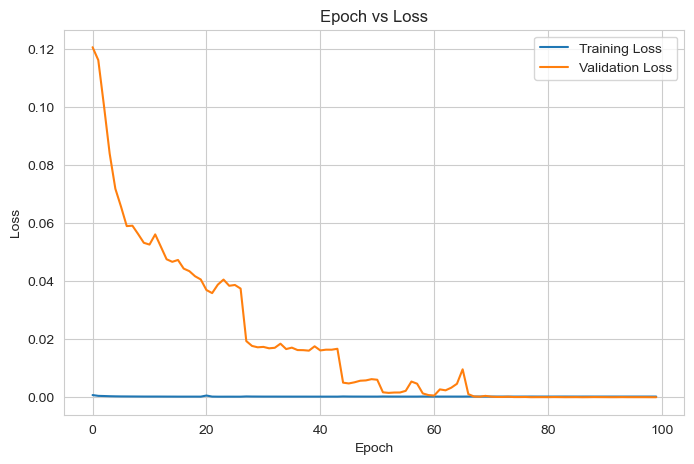

In [21]:
# 손실 시각화
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test MAE: 1044480576.000000, RMSE: 32318.424714


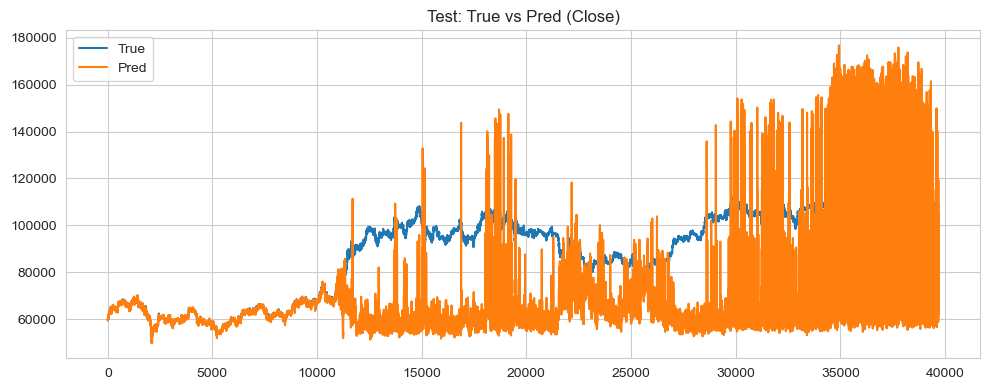

In [24]:
# 7) 예측 → 역스케일 → 실제 단위 성능 측정
y_pred_s = model.predict(X_test, verbose=0).ravel()
# (N,)->(N,1)로 바꾼 뒤 역변환
y_pred = y_scaler.inverse_transform(y_pred_s.reshape(-1,1)).ravel()
y_true = y_scaler.inverse_transform(y_test.reshape(-1,1)).ravel()

from sklearn.metrics import mean_absolute_error, mean_squared_error
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"Test MAE: {mse:.6f}, RMSE: {rmse:.6f}")

# 8) 간단 시각화 (실측 vs 예측)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(y_true, label='True')
plt.plot(y_pred, label='Pred')
plt.legend(); plt.title('Test: True vs Pred (Close)'); plt.tight_layout()
plt.show()

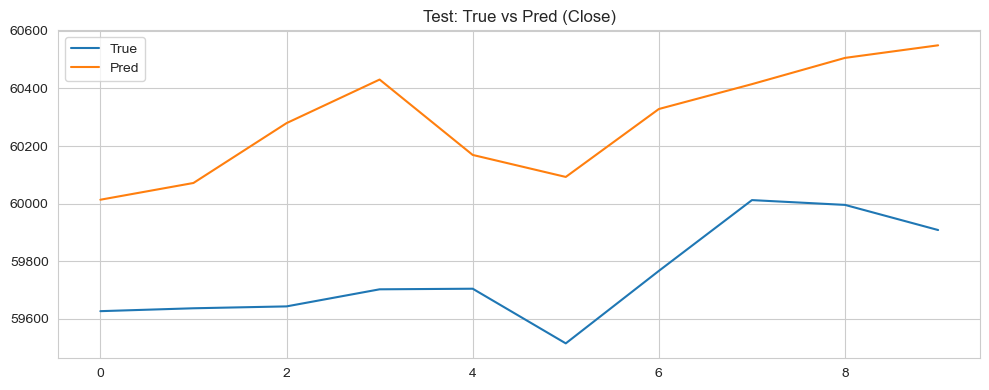

In [31]:
plt.figure(figsize=(10,4))
plt.plot(y_true[:10], label='True')
plt.plot(y_pred[10:20], label='Pred')
plt.legend(); plt.title('Test: True vs Pred (Close)'); plt.tight_layout()
plt.show()

In [34]:
import numpy as np
import pandas as pd

def directional_metrics_from_levels(y_true_level, y_pred_level, prev_true_level=None, eps=0.0):
    """
    y_true_level, y_pred_level: 같은 길이의 배열/시리즈 (예: 내일 Close의 실제/예측 레벨)
    prev_true_level: 기준이 될 '직전 실제 Close' (없으면 y_true를 한 칸 밀어서 자동 생성)
    eps: 너무 작은 변화(노이즈)를 0으로 간주하는 임계값
    """
    y_true = np.asarray(y_true_level).ravel()
    y_pred = np.asarray(y_pred_level).ravel()

    if prev_true_level is None:
        prev_true = np.roll(y_true, 1)
        # 첫 샘플은 직전값이 없어 비교 불가 → 제거
        y_true = y_true[1:]
        y_pred = y_pred[1:]
        prev_true = prev_true[1:]
    else:
        prev_true = np.asarray(prev_true_level).ravel()
        assert len(prev_true) == len(y_true)

    real_delta = y_true - prev_true
    pred_delta = y_pred - prev_true

    real_sign = np.sign(np.where(np.abs(real_delta) <= eps, 0.0, real_delta))
    pred_sign = np.sign(np.where(np.abs(pred_delta) <= eps, 0.0, pred_delta))

    mask = real_sign != 0  # 변화가 전혀 없는 구간(=0)은 제외
    hit_rate = float((pred_sign[mask] == real_sign[mask]).mean()) if mask.any() else np.nan

    # 혼동행렬(상승/하락만)
    from sklearn.metrics import confusion_matrix
    labels = [-1, 1]
    cm = confusion_matrix(real_sign[mask], pred_sign[mask], labels=labels)

    return {
        "hit_rate": hit_rate,
        "n_eval": int(mask.sum()),
        "confusion_matrix": cm,  # rows: 실제(-1,1), cols: 예측(-1,1)
        "labels": labels
    }


In [37]:
# (필요 시 역스케일)
# y_true = y_scaler.inverse_transform(y_true.reshape(-1,1)).ravel()
# y_pred = y_scaler.inverse_transform(y_pred.reshape(-1,1)).ravel()

res = directional_metrics_from_levels(y_true[:5000], y_pred[:5000], prev_true_level=None, eps=0.0)
print("방향 적중률:", res["hit_rate"])
print("평가 샘플 수:", res["n_eval"])
print("혼동행렬:\n", res["confusion_matrix"])

방향 적중률: 0.49899879855826995
평가 샘플 수: 4994
혼동행렬:
 [[1531  956]
 [1546  961]]
